In [4]:
import numpy as np
import pandas
import pylab as plt  # matplotlib的一个子包
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error # 平方绝对误差
from sklearn.metrics import r2_score  # R square

import sys 
sys.path.append(r'D:\\xueqing\\workplace\\lstm\\Time-Series-Prediction-with-LSTM')  # 要用绝对路径
from utils import eemd_tools, data_tools, networks_factory, data_metrics
from utils.constants import const

# 导入数据

In [5]:
data_multi = np.load(const.PROJECT_DIR + "/data/eemd/apple/data_multi.npy")
print("# shape", data_multi.shape)  # not .shape()
print(data_multi[0:5, :])

# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_dataset = scaler.fit_transform(data_multi)
print(scaled_dataset[0:5, :])

print("min", scaler.min_)
print("scale", scaler.scale_)

# shape (1901, 4)
[[10.71000004 -1.04730794 -0.30375276 11.70896207]
 [10.71000004 -1.2004161  -0.30634892 11.70851238]
 [10.71000004 -0.60141036 -0.3092146  11.70805801]
 [10.71000004 -1.19258193 -0.31236656 11.70759896]
 [10.71000004 -0.83063576 -0.31581461 11.70713522]]
[[-0.08158111 -0.25876501 -0.34625364  1.        ]
 [-0.08158111 -0.28206251 -0.34704883  0.9997949 ]
 [-0.08158111 -0.19091558 -0.34792656  0.99958765]
 [-0.08158111 -0.28087044 -0.34889198  0.99937828]
 [-0.08158111 -0.22579537 -0.3499481   0.99916676]]
min [-1.88309508 -0.09940275 -0.25321644 -4.34053141]
scale [0.16820859 0.15216371 0.30629255 0.4561063 ]


In [6]:
# decompose components
look_back = 13  # test one
data_components = list()
for i in range(4):
    component = scaled_dataset[:,i];
    component = component.reshape((len(component), 1))  # to be two dims for inverse_transform
    # print(component.shape)
    # print(component[0:5, :])
    
    dataX, dataY = data_tools.create_dataset(component, look_back)
    dataY = dataY.reshape((len(dataY), 1))  # to be two dims for inverse_transform
    # print("# shape: ", dataX.shape)  # lenth 应等于 len(dataset)-look_back
    # print("# shape: ", dataY.shape)
    
    data_components.append(np.concatenate((dataX, dataY), axis=1))
    
print("-----------done--------------")
print("# length: ", len(data_components))
compoment1 = data_components[0]
type(compoment1)
print(compoment1.shape)

-----------done--------------
# length:  4
(1888, 14)


# LSTM

In [7]:
time_steps = 13  # There are dependencies
n_lstm_neurons = 32
n_epoch = networks_factory.EPOCHS
n_batch_size = networks_factory.BATCH_SIZE
print("# n_epoch: ", n_epoch)
print("# n_batch_size: ", n_batch_size)

# n_epoch:  2000
# n_batch_size:  32


In [8]:
inv_data_components = list()
df_metrics = pandas.DataFrame(index=['RMSE', 'MAPE', 'Dstat'], columns=np.arange(0, len(data_components)))

for i, data_supervised in enumerate(data_components):
    # split into train and test sets
    train_size = int(len(data_supervised) * 0.80)
    test_size = len(data_supervised) - train_size
    train_data, test_data = data_supervised[0:train_size,:], data_supervised[train_size:len(data_multi),:]
   
    # split into input and outputs
    train_X, train_Y = train_data[:, :-1], train_data[:, -1]
    test_X, test_Y = test_data[:, :-1], test_data[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    print("-----------iterate: %d--------------" % i)
    train_X = train_X.reshape((train_X.shape[0], time_steps, train_X.shape[1]//time_steps))
    test_X = test_X.reshape((test_X.shape[0], time_steps, test_X.shape[1]//time_steps))
    
    # create and fit the LSTM network
    n_dims = train_X.shape[2]
    s, model = networks_factory.create_lstm_model(lstm_neurons=n_lstm_neurons, hidden_layers=2, 
                                                  lenth=time_steps, dims=n_dims, n_out=1)
    
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_Y, epochs=n_epoch, batch_size=n_batch_size, validation_data=(test_X, test_Y), 
                        verbose=0, callbacks=[networks_factory.ES])
    print("# Finished Training...")

    # make a prediction
    train_predict = model.predict(train_X)
    test_predict = model.predict(test_X)
    
    inv_data_components.append(test_predict)  # 放入列表，待集成

print("# All Done!")
# df_metrics.to_excel(const.PROJECT_DIR + "data\\eemd\\apple\\test_lookback-3.xlsx")

-----------iterate: 0--------------
Epoch 00239: early stopping
# Finished Training...
-----------iterate: 1--------------
Epoch 00212: early stopping
# Finished Training...
-----------iterate: 2--------------
Epoch 00827: early stopping
# Finished Training...
-----------iterate: 3--------------
Epoch 01261: early stopping
# Finished Training...
# All Done!


## 集成

In [9]:
# invert predictions 
component1 = inv_data_components[1]
inv_test = np.zeros(component1.shape)
for i, component in enumerate(inv_data_components):
    inv_test = np.concatenate((inv_test, inv_data_components[i]), axis=1)
    
inv_test = inv_test[:, 1:5]
print(inv_test.shape)
print(inv_test[0:2, :])

# inverse scale
inv_yhat = scaler.inverse_transform(inv_test)
print(inv_yhat.shape)
print(inv_yhat[0:2, :])
print("scale", scaler.scale_)

(378, 4)
[[-0.70552039 -0.16091402 -0.42567691 -0.63689339]
 [-0.74707735 -0.20452195 -0.42369315 -0.63804471]]
(378, 4)
[[ 7.00068118 -0.40424403 -0.56305802  8.12012021]
 [ 6.7536251  -0.69082968 -0.55658133  8.11759597]]
scale [0.16820859 0.15216371 0.30629255 0.4561063 ]


In [10]:
inv_yhat = inv_yhat[:, 1:]           # exclude original price
sum1 = inv_yhat.sum(axis=1)
sum1 = sum1.reshape((len(sum1), 1))  # to be two dims for inverse_transform
print("# shape: ", sum1.shape)

# true 
price = data_multi[:,0];
price = price.reshape((len(price), 1))  # to be two dims for inverse_transform
price = price[-378:, :]
print("# shape: ", price.shape)

# shape:  (378, 1)
# shape:  (378, 1)


In [11]:
# calculate RMSE, MAPE, Dstat
test_rmse = sqrt(mean_squared_error(sum1, price))
print('Test RMSE: %.4f' % (test_rmse))
test_mape = data_metrics.MAPE(sum1, price)
print('Test MAPE: %.4f' % (test_mape))
test_ds = data_metrics.Dstat(sum1, price)
print('Test Dstat: %.4f' % (test_ds))


Test RMSE: 0.3667
Test MAPE: 0.0364
Test Dstat: 0.6764


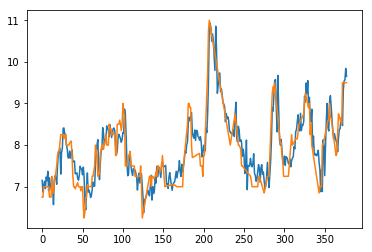

In [13]:
# plot
plt.plot(sum1, label='sum')
plt.plot(price, label='true')  # begin 7
plt.show()

# Plot

In [50]:
import matplotlib
from datetime import datetime

dataset, dates = data_tools.load_data_from_csv(const.PROJECT_DIR + "/data/apple_interpolate.csv")
plt.rcParams['font.family']=['STSong']
ys, xs = dataset, [datetime.strptime(d, '%Y-%m-%d') for d in dates]
type(xs)

list

In [49]:
a=sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])

# for i in a:
#     print(i)

Agency FB
Agency FB
Algerian
Arial
Arial
Arial
Arial
Arial
Arial
Arial
Arial
Arial
Arial Rounded MT Bold
Arial Unicode MS
Bahnschrift
Baskerville Old Face
Bauhaus 93
Bell MT
Bell MT
Bell MT
Berlin Sans FB
Berlin Sans FB
Berlin Sans FB Demi
Bernard MT Condensed
Blackadder ITC
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Book Antiqua
Book Antiqua
Book Antiqua
Book Antiqua
Bookman Old Style
Bookman Old Style
Bookman Old Style
Bookman Old Style
Bookshelf Symbol 7
Bradley Hand ITC
Britannic Bold
Broadway
Brush Script MT
Calibri
Calibri
Calibri
Calibri
Calibri
Calibri
Californian FB
Californian FB
Californian FB
Calisto MT
Calisto MT
Calisto MT
Calisto MT
Cambria
Cambria
Cambria
Candara
Candara
Candara
Candara
Candara
Candara
Castellar
Centaur
Century
Century Gothic
Century Gothic
Century Gothic
Century Gothic
Century Schoolbook
Century Schoolbook
Century Schoolbook
Century Schoolbook
Chiller
Colonna MT
Comic Sans MS
Comic Sans

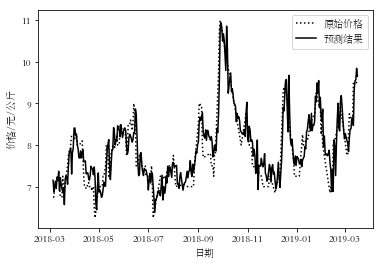

In [52]:
xs = np.array(xs)
xs = xs[-378:]

fig = plt.figure(1)
ax1 = plt.subplot(1, 1, 1)
l1, = ax1.plot(xs, price, color='black', linestyle=':')
l2, = ax1.plot(xs, sum1, color='black', linestyle='-')

plt.ylabel('价格/元/公斤')
plt.xlabel('日期')
plt.legend([l1, l2], ['原始价格', '预测结果'], loc='upper right')
plt.show()